# Model 1. Understanding the accuracy of current endonasal image guidance system.

The current state of the art uses a tracked pointer, registered to a pre-operative MR scan. This notebook explores what the expected level of accuracy might be.






In [151]:
import numpy as np
import random
from matplotlib import pyplot as plt
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.transforms.matrix as mu


## Utility functions

Here follows some useful utility functions. Scroll down to see the start of the analysis.

In [152]:
def create_transform(array_of_parameters):
    """
    Returns a homogeneous rigid transformation as 4x4 np.ndarray.
    
    :param array_of_parameters: list of [tx, ty, tz, rx, ry, rz] where rotations are in degrees.
    """
    rotation = mu.construct_rotm_from_euler(array_of_parameters[3],
                                            array_of_parameters[4],
                                            array_of_parameters[5],
                                            sequence='xyz',
                                            is_in_radians=False)
    translation = np.zeros((3,1))
    translation[0][0] = array_of_parameters[0]
    translation[1][0] = array_of_parameters[1]
    translation[2][0] = array_of_parameters[2]
    
    transform = mu.construct_rigid_transformation(rotation, translation)
    return transform
    
def multiply_points_by_matrix(matrix_4x4, matrix_of_points, do_transpose):
    """
    Multiplies all points by the same matrix.
    
    :param matrix_4x4: Numpy ndarray, 4x4, containing homogenous, rigid transformation
    :param matrix_of_points: Numpy ndarray, 4xN, containing N points as 4D homogeneous column vectors.
    :param do_transpose: if true, we also transpose
    """
    input_matrix = matrix_of_points
    
    if do_transpose:
        input_matrix = np.transpose(matrix_of_points)
        
    result = np.matmul(matrix_4x4, input_matrix)
    
    if do_transpose:
        result = np.transpose(result)
        
    return result

def multiply_point_by_matrix(transform, point_as_array):
    in_point = np.ones((4, 1))
    in_point[0][0] = point_as_array[0]
    in_point[1][0] = point_as_array[1]
    in_point[2][0] = point_as_array[2]
    out_point = np.matmul(transform, in_point)
    return out_point
    
def pointer_to_mri(Cam_T_PntRef, Cam_T_PatRef, PatRef_T_MRI, point_in_pointer_coords=[0, 0, 0]):
    """
    Converts a point in pointer space to MRI space.
    """
    transform = np.linalg.inv(PatRef_T_MRI) @ np.linalg.inv(Cam_T_PatRef) @ Cam_T_PntRef
    out_point = multiply_point_by_matrix(transform, point_in_pointer_coords)
    return out_point

def add_noise_to_points(points_in, sigma):
    points_out = np.zeros((points_in.shape))
    for r in range(points_in.shape[0]):
        for c in range(points_in.shape[1]):
            points_out[r][c] = points_in[r][c] + random.normalvariate(0, sigma)
    return points_out


## System layout

The following diagram shows the layout of the navigation system.

![img](./images/pointer_setup.png)

In the above image, we can see the general setup involved in the surgery when using a pointer. The goal is to be able to display the pointer in image coordinates as we can see in the image below:

![pointer on MRI](./images/MRI_pointer.png)

The goal is therefore turning the pointer's coordinates to MRI coordinates.

X<sub>MRI</sub> = T X<sub>PntEnd</sub>

where T are the transformations involved in turning from the pointer's point to the MRI coordinates. These transformations are the following:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>endP</sub>
    
In the following sections we will go step by step on how to go from each of these transforms

Here is an image with all the transforms:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

## Assumptions / setup

1. Cancer, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is D

2. Patient reference is at a set distance Yc from the cancer but aligned in the X direction

3. pointer is touching the cancer, so the pointer and cancer have the same coordinates

4. Length of pointer is known

5. Angle of pointer is known

![pointer assumptions from sagittal view](./images/pointer_setup_assumptions_sagittal.png)
![pointer assumptions from transverse view](./images/pointer_setup_assumptions_transverse.png)

## Configurable parameters

In [153]:
# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
pointer_length = 100

# D - z distance from camera to plane where everything is located
distance_from_cam = 1000 # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 0 - angle of pointer
pointer_angle = 45

# Yc - distances from cancer to patient reference
cancer_patref_y = 50  

## Creating the reference data for the pointer, in pointer coordinates.

Here is an image of the pointer with its reference:

![pointer image](./images/pointer_image.png)
![pointer image](./images/pointer_geometry.png)

In our case, let us assume we already know what the length of the pointer is.

In [154]:
print(f'pointer length is: {pointer_length}mm' )

pointer length is: 100mm


[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]


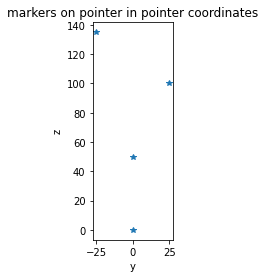

In [155]:
# Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
pnt_ref =  np.zeros((4, 4))
pnt_ref[0][3] = 1
pnt_ref[1][2] = 50
pnt_ref[1][3] = 1
pnt_ref[2][1] = 25
pnt_ref[2][2] = 100
pnt_ref[2][3] = 1
pnt_ref[3][1] = -25
pnt_ref[3][2] = 135
pnt_ref[3][3] = 1
print(pnt_ref)

# Plotting original points, to check it looks ok.
plt.figure()
plt.plot(pnt_ref[:,1],pnt_ref[:,2], marker='*',linestyle = 'None',)
plt.title('markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


Original pointer, as per datasheet:
[[  0.   0.   0.   1.]
 [  0.   0.  50.   1.]
 [  0.  25. 100.   1.]
 [  0. -25. 135.   1.]]
offset_pointer_transform=
[[  1.   0.   0.   0.]
 [  0.   1.   0.   0.]
 [  0.   0.   1. 100.]
 [  0.   0.   0.   1.]]
pnt_ref_transformed=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]]
pnt_ref_with_tip=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]


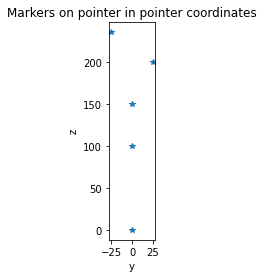

In [156]:
# Here we offset the points by the length of the pointer.
offset_pointer_transform = create_transform([0, 0, pointer_length, 0, 0, 0])
pnt_ref_transformed = multiply_points_by_matrix(offset_pointer_transform, pnt_ref, do_transpose=True)
pnt_ref_with_tip = np.concatenate((pnt_ref_transformed, [[0, 0, 0, 1]]), axis=0)

print("Original pointer, as per datasheet:\n" + str(pnt_ref))
print("offset_pointer_transform=\n" + str(offset_pointer_transform))
print("pnt_ref_transformed=\n" + str(pnt_ref_transformed))
print("pnt_ref_with_tip=\n" + str(pnt_ref_with_tip))

plt.figure()
plt.plot(pnt_ref_with_tip[:,1],pnt_ref_with_tip[:,2], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in pointer coordinates')
plt.xlabel('y')
plt.ylabel('z')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Creating the reference data for the pointer in camera coordinates

Pointer in camera/tracker space:
[[  0.   0.   0.   1.]
 [ 50.   0.   0.   1.]
 [100.  25.   0.   1.]
 [135. -25.   0.   1.]]
offset_pointer_transform=
[[  1.   0.   0. 100.]
 [  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_transformed=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]]
pnt_ref_in_camera_space_with_tip=
[[100.   0.   0.   1.]
 [150.   0.   0.   1.]
 [200.  25.   0.   1.]
 [235. -25.   0.   1.]
 [  0.   0.   0.   1.]]
pnt_ref_in_camera_space_at_patient=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]


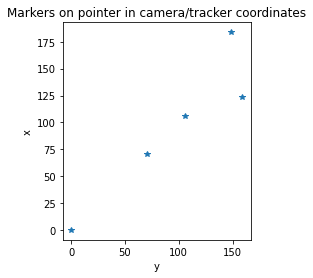

In [157]:
pnt_ref_in_camera_space =  np.zeros((4, 4))
pnt_ref_in_camera_space[0][3] = 1
pnt_ref_in_camera_space[1][0] = 50
pnt_ref_in_camera_space[1][3] = 1
pnt_ref_in_camera_space[2][0] = 100
pnt_ref_in_camera_space[2][1] = 25
pnt_ref_in_camera_space[2][3] = 1
pnt_ref_in_camera_space[3][0] = 135
pnt_ref_in_camera_space[3][1] = -25
pnt_ref_in_camera_space[3][3] = 1

offset_pointer_transform = create_transform([pointer_length, 0, 0, 0, 0, 0])
pnt_ref_in_camera_space_transformed = multiply_points_by_matrix(offset_pointer_transform, pnt_ref_in_camera_space, do_transpose=True)
pnt_ref_in_camera_space_with_tip = np.concatenate((pnt_ref_in_camera_space_transformed, [[0, 0, 0, 1]]), axis=0)

print("Pointer in camera/tracker space:\n" + str(pnt_ref_in_camera_space))
print("offset_pointer_transform=\n" + str(offset_pointer_transform))
print("pnt_ref_in_camera_space_transformed=\n" + str(pnt_ref_in_camera_space_transformed))
print("pnt_ref_in_camera_space_with_tip=\n" + str(pnt_ref_in_camera_space_with_tip))

# Now we want to rotate around z (according to diagram above), then translate to a distance from camera.
rotate_about_z = create_transform([0, 0, 0, 0, 0, pointer_angle]) 
translate_away_from_camera = create_transform([0, 0, distance_from_cam, 0, 0, 0])
pnt_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_away_from_camera @ rotate_about_z, pnt_ref_in_camera_space_with_tip, do_transpose=True)
print("pnt_ref_in_camera_space_at_patient=\n" + str(pnt_ref_in_camera_space_at_patient))

# Plotting result
plt.figure()
plt.plot(pnt_ref_in_camera_space_at_patient[:,1],pnt_ref_in_camera_space_at_patient[:,0], marker='*',linestyle = 'None',)
plt.title('Markers on pointer in camera/tracker coordinates')
plt.xlabel('y')
plt.ylabel('x')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Computing the Tracking transformation, Cam_T_PntRef.

For sanity checking, we should now be able to register the PntRef model (moving) to Cam (fixed) transform.

In [158]:
Cam_T_PntRef_r, Cam_T_PntRef_t, Cam_T_PntRef_FRE = pro.orthogonal_procrustes(pnt_ref_in_camera_space_at_patient[:,0:3], pnt_ref_with_tip[:,0:3])
print("Cam_T_PntRef_r=\n" + str(Cam_T_PntRef_r))
print("Cam_T_PntRef_t=\n" + str(Cam_T_PntRef_t))
print("Cam_T_PntRef_FRE=\n" + str(Cam_T_PntRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a rotation and a translation.
Cam_T_PntRef = mu.construct_rigid_transformation(Cam_T_PntRef_r, Cam_T_PntRef_t)
print("Cam_T_PntRef=\n" + str(Cam_T_PntRef))


Cam_T_PntRef_r=
[[ 9.30802688e-16 -7.07106781e-01  7.07106781e-01]
 [-9.82060848e-16  7.07106781e-01  7.07106781e-01]
 [-1.00000000e+00 -1.37390099e-15  1.11022302e-16]]
Cam_T_PntRef_t=
[[4.26325641e-14]
 [2.84217094e-14]
 [1.00000000e+03]]
Cam_T_PntRef_FRE=
5.961788066145753e-14
Cam_T_PntRef=
[[ 9.30802688e-16 -7.07106781e-01  7.07106781e-01  4.26325641e-14]
 [-9.82060848e-16  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -1.37390099e-15  1.11022302e-16  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Creating reference data for the the Patient Reference

![real patient reference](./images/real_pat_ref.png)


![patient reference coordinates](./images/pointer_patref_marker.png)

In [159]:
# Defining reference coordibates in ref coords (from datasheet)
#A: x=0.00, y= 0.00, z=0.00 
#B: x=0.00, y= 28.59, z=41.02 
#C: x=0.00, y= 00.00, z=88.00 
#D: x=0.00, y=-44.32, z=40.45
    
# Encoding the reference marker points into a numpy matrix
pat_ref = np.zeros((4, 4))
pat_ref[0][3] = 1.0
pat_ref[1][1] = 28.59 
pat_ref[1][2] = 41.02
pat_ref[1][3] = 1.0
pat_ref[2][2] = 88 
pat_ref[2][3] = 1.0
pat_ref[3][1] = -44.32 
pat_ref[3][2] = 40.45
pat_ref[3][3] = 1.0

## Creating the reference data for the patient reference in camera space.

- we assume the patient reference centre is at the same level as the cancer and so the x coordinates are the same
- the distance in y direction between cancer and reference is known


![reminder of patient reference assumptions](./images/pat_ref_assumptions.png)

The patient reference model coordinates are in the YZ plane. In camera space, the X direction is vertical, the Z direction goes from the camera to the patient. So, in camera space, lets place these points in the ZY plane. So, all we have to do is swap the Y, Z coordinates, then translate to the patient, then translate along the negative Y axis to match the picture above. 


In [160]:
# Encoding the reference marker points into a numpy matrix, in camera space.
pat_ref_in_camera_space = np.zeros((4, 4))
pat_ref_in_camera_space[0][3] = 1.0 
pat_ref_in_camera_space[1][1] = 41.02
pat_ref_in_camera_space[1][2] = 28.59
pat_ref_in_camera_space[1][3] = 1.0
pat_ref_in_camera_space[2][1] = 88 
pat_ref_in_camera_space[2][3] = 1.0
pat_ref_in_camera_space[3][1] = 40.45
pat_ref_in_camera_space[3][2] = -44.32 
pat_ref_in_camera_space[3][3] = 1.0

# Now put it in the right place.
translate_along_negative_y = create_transform([0, -cancer_patref_y, 0, 0, 0, 0])
pat_ref_in_camera_space_at_patient = multiply_points_by_matrix(translate_along_negative_y @ translate_away_from_camera, pat_ref_in_camera_space, do_transpose=True)

print("Patient ref, in model coordinates=\n" + str(pat_ref))
print("Patient ref, in camera coordinates=\n" + str(pat_ref_in_camera_space_at_patient))



Patient ref, in model coordinates=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref, in camera coordinates=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


## Computing the Tracking transformation Cam_T_PntRef

In [161]:

# As above, compute the tracking transformation.
Cam_T_PatRef_r, Cam_T_PatRef_t, Cam_T_PatRef_FRE = pro.orthogonal_procrustes(pat_ref_in_camera_space_at_patient[:,0:3], pat_ref[:,0:3])
print("Cam_T_PatRef_r=\n" + str(Cam_T_PatRef_r))
print("Cam_T_PatRef_t=\n" + str(Cam_T_PatRef_t))
print("Cam_T_PatRef_FRE=\n" + str(Cam_T_PatRef_FRE))

# Also, construct a 4x4 tracking transformation. It should look like a translation, with no rotation.
Cam_T_PatRef = mu.construct_rigid_transformation(Cam_T_PatRef_r, Cam_T_PatRef_t)
print("Cam_T_PatRef=\n" + str(Cam_T_PatRef))


Cam_T_PatRef_r=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.17961196e-16  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -1.11022302e-16]]
Cam_T_PatRef_t=
[[   0.]
 [ -50.]
 [1000.]]
Cam_T_PatRef_FRE=
9.39959687352353e-15
Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.17961196e-16  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -1.11022302e-16  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## CT to PatRef coordinates

In order to convert CT coordinates to patient reference coordinates, we typically would take the pointer and move it over the surface of the patient's head. The software would collect coordinates of the tip of the pointer, and transform them to the patient reference coordinate system. We then use an ICP algorithm to match the two surfaces of the points on the face. This results in PatRef_T_MRI as shown above.

For the purpose of this simulation, we can just place them at an offset to the patient reference, which has already been placed, somewhere near the patients head.

![MRI to camera coordinates](./images/3D_to_cam.png)

In [162]:
# Average head dimensions from: https://en.wikipedia.org/wiki/Human_head

x_t = 100 # head length (about 20cm)
y_t = 130 # menton to top of head (about 25cm)
z_t = 80 # head bredth (about 15cm)

PatRef_T_MRI = create_transform([-x_t, -y_t, -z_t, 0, 0, 0])
print("Cam_T_PntRef=\n" + str(PatRef_T_MRI))

Cam_T_PntRef=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


# Summary of Reference data.

Give this setup:

![pointer setup with transforms](./images/pointer_setup_transforms.png)

we have now computed

In [163]:
print("Summary: Cam_T_PntRef=\n" + str(Cam_T_PntRef))
print("Summary: Cam_T_PatRef=\n" + str(Cam_T_PatRef))
print("Summary: PatRef_T_MRI=\n" + str(PatRef_T_MRI))

Summary: Cam_T_PntRef=
[[ 9.30802688e-16 -7.07106781e-01  7.07106781e-01  4.26325641e-14]
 [-9.82060848e-16  7.07106781e-01  7.07106781e-01  2.84217094e-14]
 [-1.00000000e+00 -1.37390099e-15  1.11022302e-16  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: Cam_T_PatRef=
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.17961196e-16  1.00000000e+00 -5.00000000e+01]
 [ 0.00000000e+00  1.00000000e+00 -1.11022302e-16  1.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Summary: PatRef_T_MRI=
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]


and dont forget that we constructed the pointer, so that the origin is the tip, and we computed Cam_T_PntRef based on this. So, in the above diagram, PntRef_T_EndP is effectively the identity transformation.

In addition, we can just place the tumour at the location given by the pointer tip:


In [164]:
origin = [0, 0, 0]
tumour_in_camera_space = multiply_point_by_matrix(Cam_T_PntRef, origin)
tumour_in_mri_space = pointer_to_mri(Cam_T_PntRef, Cam_T_PatRef, PatRef_T_MRI, origin)
print("Tumour location in camera space=\n" + str(tumour_in_camera_space))
print("Tumour location in MRI space=\n" + str(tumour_in_mri_space))


Tumour location in camera space=
[[4.26325641e-14]
 [2.84217094e-14]
 [1.00000000e+03]
 [1.00000000e+00]]
Tumour location in MRI space=
[[100.]
 [130.]
 [130.]
 [  1.]]


And we have the following reference data from above:

In [165]:
print("Pointer model=\n" + str(pnt_ref_with_tip))
print("Pointer model in camera space=\n" + str(pnt_ref_in_camera_space_at_patient))
print("Patient ref model=\n" + str(pat_ref))
print("Patient ref model in camera space=\n" + str(pat_ref_in_camera_space_at_patient))


Pointer model=
[[  0.   0. 100.   1.]
 [  0.   0. 150.   1.]
 [  0.  25. 200.   1.]
 [  0. -25. 235.   1.]
 [  0.   0.   0.   1.]]
Pointer model in camera space=
[[  70.71067812   70.71067812 1000.            1.        ]
 [ 106.06601718  106.06601718 1000.            1.        ]
 [ 123.74368671  159.09902577 1000.            1.        ]
 [ 183.84776311  148.49242405 1000.            1.        ]
 [   0.            0.         1000.            1.        ]]
Patient ref model=
[[  0.     0.     0.     1.  ]
 [  0.    28.59  41.02   1.  ]
 [  0.     0.    88.     1.  ]
 [  0.   -44.32  40.45   1.  ]]
Patient ref model in camera space=
[[ 0.00000e+00 -5.00000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -8.98000e+00  1.02859e+03  1.00000e+00]
 [ 0.00000e+00  3.80000e+01  1.00000e+03  1.00000e+00]
 [ 0.00000e+00 -9.55000e+00  9.55680e+02  1.00000e+00]]


which are the 4 sets of points that we computed tracking transformations from, using orthogonal procrustes.

# Simulation 1: Effect of tracking noise on pointer tip accuracy.

Here we add random noise to the location of the tracking markers (pointer and patient ref) and see how far tip position moves relative to the tumour.

### Pseudo code

* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0.1 to 1, in steps of 0.1
*   for iteration in 1 to 10,000.
*     add zero mean Gaussian(sigma) noise to each tracking marker. 
*     recompute transforms.
*     recompute position of pointer tip
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma


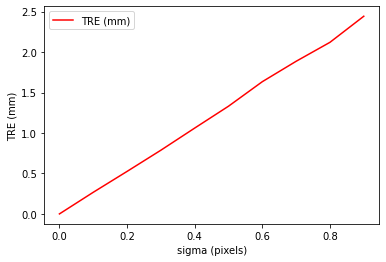

In [166]:
number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        tmp_pointer = add_noise_to_points(pnt_ref_in_camera_space_at_patient[0:4,0:3], sigma) # Mustn't include pointer tip! 
        tmp_ref = add_noise_to_points(pat_ref_in_camera_space_at_patient[:,0:3], sigma)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_pointer, pnt_ref_with_tip[0:4, 0:3])
        tmp_pointer_to_cam = mu.construct_rigid_transformation(R, t)
        
        R, t, FRE = pro.orthogonal_procrustes(tmp_ref, pat_ref[0:4, 0:3])
        tmp_reference_to_cam = mu.construct_rigid_transformation(R, t)
        
        pointer_tip_in_mri_space = pointer_to_mri(tmp_pointer_to_cam, tmp_reference_to_cam, PatRef_T_MRI, origin)
        
        euclid_dist =  (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     * (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
                     + (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     * (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
                     + (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2]) \
                     * (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2])
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('TRE (mm)')
plt.show()
        

        
        

# Other Experiments?

Can add other experiments here. What is the effect of changing the length of the pointer? Or distance from tracker?

If I wanted to test how critical the MR to PatRef registration was, I'd create 4 points in CT space and multiply them by PatRef_T_MRI to get the same 4 points in the patient reference space. This isn't an ICP obviously. You'd just have to have a set of points that sort of represent what might be 4 fiducials on the surface of a head. Then you can do the same type of simulation as above, simulating progressively worse fiducial based registration. That's probably enough.